# Propogation of a Bistable System

All the above models have been well-mixed, that is point or non-spatial
models. Bistables do interesting things when they are dispersed in space.
This is illustrated in this example. Here we have a tapering cylinder,
that is a pseudo 1-dimensional reaction-diffusion system. Every point in
this cylinder has the bistable system from the strongBis example.

<img src = "propBis.png" width="50%">

The example has two stages. First it starts out with the model in the 
unstable transition point, and introduces a small symmetry-breaking
perturbation at one end. This rapidly propagates through the entire
length model, leaving molecule **b** at a higher value than **c**.

At t = 100 we carry out a different manipulation. We flip the concentrations
of molecules b and c for the left half of the model, and then just let it run.
Now we have opposing bistable states on either half. In the middle, the two
systems battle it out. Molecule **c** from the left side diffuses over to the 
right, and tries to inhibit **b**, and vice versa.
However we have a small asymmetry due to the tapering of the cylinder. As there
is a slightly larger volume on the left, the transition point gradually 
advances to the right, as molecule **b** yields to the slightly larger
amounts of molecule **c**.

('dsolve.numPools, num = ', 7L, 200)
Swapping concs of b and c in half the cylinder
Hit 'enter' to exit


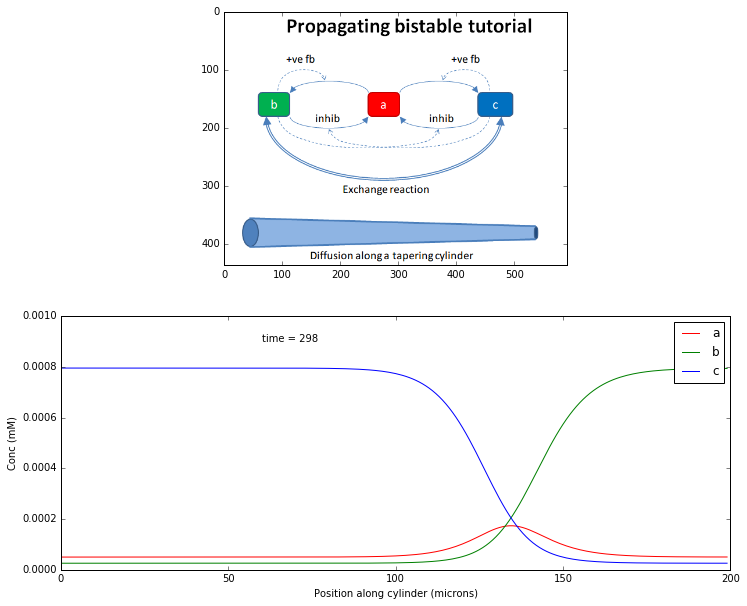

In [1]:
#########################################################################
## This program is part of 'MOOSE', the
## Messaging Object Oriented Simulation Environment.
##           Copyright (C) 2014 Upinder S. Bhalla. and NCBS
## It is made available under the terms of the
## GNU Lesser General Public License version 2.1
## See the file COPYING.LIB for the full notice.
#########################################################################

"""
This example illustrates propagation of state flips in a 
linear 1-dimensional reaction-diffusion system. It uses a 
bistable system loaded in from a kkit definition file, and
places this in a tapering cylinder for pseudo 1-dimentionsional 
diffusion.

This example illustrates a number of features of reaction-diffusion
calculations. 

First, it shows how to set up such systems. Key steps are to create
the compartment and define its voxelization, then create the Ksolve, 
Dsolve, and Stoich. Then we assign stoich.compartment, ksolve and
dsolve in that order. Finally we assign the path of the Stoich.

For running the model, we start by introducing
a small symmetry-breaking increment of concInit
of the molecule **b** in the last compartment on the cylinder. The model
starts out with molecules at equal concentrations, so that the system would
settle to the unstable fixed point. This symmetry breaking leads
to the last compartment moving towards the state with an 
increased concentration of **b**,
and this effect propagates to all other compartments.

Once the model has settled to the state where **b** is high throughout, 
we simply exchange the concentrations of **b** with **c** in the left
half of the cylinder. This introduces a brief transient at the junction,
which soon settles to a smooth crossover.

Finally, as we run the simulation, the tapering geometry comes into play.
Since the left hand side has a larger diameter than the right, the
state on the left gradually wins over and the transition point slowly
moves to the right.

"""

%matplotlib inline

import math
import numpy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import moose
import sys

def makeModel():
                # create container for model
                r0 = 1e-6        # m
                r1 = 0.5e-6        # m. Note taper.
                num = 200
                diffLength = 1e-6 # m
                comptLength = num * diffLength        # m
                diffConst = 20e-12 # m^2/sec
                concA = 1 # millimolar
                diffDt = 0.02  # for the diffusion
                chemDt = 0.2   # for the reaction
                mfile = './M1719.g'

                model = moose.Neutral( 'model' )
                compartment = moose.CylMesh( '/model/kinetics' )

                # load in model
                modelId = moose.loadModel( mfile, '/model', 'ee' )
                a = moose.element( '/model/kinetics/a' )
                b = moose.element( '/model/kinetics/b' )
                c = moose.element( '/model/kinetics/c' )

                ac = a.concInit
                bc = b.concInit
                cc = c.concInit

                compartment.r0 = r0
                compartment.r1 = r1
                compartment.x0 = 0
                compartment.x1 = comptLength
                compartment.diffLength = diffLength
                assert( compartment.numDiffCompts == num )

                # Assign parameters
                for x in moose.wildcardFind( '/model/kinetics/##[ISA=PoolBase]' ):
                    #print 'pools: ', x, x.name
                    x.diffConst = diffConst

                # Make solvers
                ksolve = moose.Ksolve( '/model/kinetics/ksolve' )
                dsolve = moose.Dsolve( '/model/dsolve' )
                # Set up clocks.
                moose.setClock( 10, diffDt )
                for i in range( 11, 17 ):
                    moose.setClock( i, chemDt )

                stoich = moose.Stoich( '/model/kinetics/stoich' )
                stoich.compartment = compartment
                stoich.ksolve = ksolve
                stoich.dsolve = dsolve
                stoich.path = "/model/kinetics/##"
                print(('dsolve.numPools, num = ', dsolve.numPools, num))
                b.vec[num-1].concInit *= 1.01 # Break symmetry.

def main():
                runtime = 100
                displayInterval = 2
                makeModel()
                dsolve = moose.element( '/model/dsolve' )
                moose.reinit()
                #moose.start( runtime ) # Run the model for 10 seconds.

                a = moose.element( '/model/kinetics/a' )
                b = moose.element( '/model/kinetics/b' )
                c = moose.element( '/model/kinetics/c' )

                img = mpimg.imread( 'propBis.png' )
                #imgplot = plt.imshow( img )
                #plt.show()

                plt.ion()
                fig = plt.figure( figsize=(12,10) )
                png = fig.add_subplot(211)
                imgplot = plt.imshow( img )
                ax = fig.add_subplot(212)
                ax.set_ylim( 0, 0.001 )
                plt.ylabel( 'Conc (mM)' )
                plt.xlabel( 'Position along cylinder (microns)' )
                pos = numpy.arange( 0, a.vec.conc.size, 1 )
                line1, = ax.plot( pos, a.vec.conc, 'r-', label='a' )
                line2, = ax.plot( pos, b.vec.conc, 'g-',  label='b' )
                line3, = ax.plot( pos, c.vec.conc, 'b-', label='c' )
                timeLabel = plt.text(60, 0.0009, 'time = 0')
                plt.legend()
                fig.canvas.draw()

                for t in range( displayInterval, runtime, displayInterval ):
                    moose.start( displayInterval )
                    line1.set_ydata( a.vec.conc )
                    line2.set_ydata( b.vec.conc )
                    line3.set_ydata( c.vec.conc )
                    timeLabel.set_text( "time = %d" % t )
                    fig.canvas.draw()

                print('Swapping concs of b and c in half the cylinder')
                for i in range( b.numData/2 ):
                    temp = b.vec[i].conc
                    b.vec[i].conc = c.vec[i].conc
                    c.vec[i].conc = temp

                newruntime = 200
                for t in range( displayInterval, newruntime, displayInterval ):
                    moose.start( displayInterval )
                    line1.set_ydata( a.vec.conc )
                    line2.set_ydata( b.vec.conc )
                    line3.set_ydata( c.vec.conc )
                    timeLabel.set_text( "time = %d" % (t + runtime) )
                    fig.canvas.draw()

                print( "Hit 'enter' to exit" )
                sys.stdin.read(1)



# Run the 'main' if this script is executed standalone.
if __name__ == '__main__':
        main()

Unfortunately, Jupyter only shows the output graph once its finished settling. However, it is interesting to see how it evolves over time. The GIF below shows that process


<img src="propBis.gif">